# ETL Workflow for Global Forest Cover Change Analysis

In [1]:
import os
import shutil
from datetime import datetime
import rasterio
import pystac
from pystac_client import Client
import geopandas as gpd
from shapely.geometry import box, Polygon, shape
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt 
import zarr
import dask
import dask.distributed
from dask.distributed import Client
import dask.array as da
from dask.diagnostics import ProgressBar

In [2]:
# Better visualization
plt.style.use('ggplot')

In [68]:
!pip show xarray rioxarray zarr

Name: xarray
Version: 2024.7.0
Summary: N-D labeled arrays and datasets in Python
Home-page: 
Author: 
Author-email: xarray Developers <xarray@googlegroups.com>
License: Apache-2.0
Location: c:\users\hp\appdata\roaming\python\python310\site-packages
Requires: pandas, packaging, numpy
Required-by: rioxarray, odc-stac
---
Name: rioxarray
Version: 0.17.0
Summary: geospatial xarray extension powered by rasterio
Home-page: 
Author: 
Author-email: 
License: Apache
Location: c:\users\hp\appdata\roaming\python\python310\site-packages
Requires: numpy, xarray, rasterio, packaging, pyproj
Required-by: 
---
Name: zarr
Version: 2.7.0
Summary: An implementation of chunked, compressed, N-dimensional arrays for Python.
Home-page: https://github.com/zarr-developers/zarr-python
Author: 
Author-email: 
License: MIT
Location: c:\users\hp\appdata\roaming\python\python310\site-packages
Requires: fasteners, asciitree, numcodecs, numpy
Required-by: 


In [3]:
DASK_TEMP_DIR = os.environ.get('DASK_TEMP_DIR', '/tmp/dask/')

print(DASK_TEMP_DIR)

/tmp/dask/


In [20]:

# Initialize Dask client with 4 workers
client = Client(n_workers=4)
client.ncores()

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62426 instead
  warnings.warn(


{'tcp://127.0.0.1:62477': 1,
 'tcp://127.0.0.1:62478': 1,
 'tcp://127.0.0.1:62480': 1,
 'tcp://127.0.0.1:62484': 1}

2024-09-08 23:16:08,111 - distributed.core - INFO - Event loop was unresponsive in Nanny for 4.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-09-08 23:16:08,120 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 5.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-09-08 23:16:08,144 - distributed.core - INFO - Event loop was unresponsive in Nanny for 5.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-09-08 23:16:08,140 - distributed.core - INFO - Event loop was unresponsive in Nanny for 4.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-09-08 23:16:08,147 - distributed.core - INFO - Event loop w

In [6]:
DATA_DIR = 'kimongo_ndvi_archive'
ZARR_STORE = os.path.join(DATA_DIR, 'kimongo.zarr')

In [7]:
def log_progress(message): 
    timestamp_format = '%Y-%h-%d-%H:%M:%S' # Year-Monthname-Day-Hour-Minute-Second 
    now = datetime.now() # get current timestamp 
    timestamp = now.strftime(timestamp_format) 
    with open("./log/ndvi_log.txt","a") as f: 
        f.write(timestamp + ' : ' + message + '\n')

In [8]:
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
else :
    pass
    # shutil.rmtree(DATA_DIR)
    # os.makedirs(DATA_DIR)

In [9]:
# Function to create a STAC item for the Sentinel-2 product
def create_stac_item(product_info, aoi):
    item_id = product_info["name"]
    item = pystac.Item(
        id=item_id,
        geometry=aoi,
        bbox=(12.834091, -4.56342, 13.07579, -4.39776),
        datetime=datetime.fromisoformat(product_info["sensing_time"].replace("Z", "+00:00")),
        properties={
            "cloud_coverage": product_info["cloud_cover"],
            "platform": product_info["platform_short_name"],
            "instrument": product_info["instrument_short_name"],
            "absolute_orbit": product_info["absolute_orbit_number"],
            "beginning_datetime": product_info["beginning_datetime"],
            "ending_datetime": product_info["ending_datetime"],
            "processing_level": product_info["processing_level"],
            "product_id": product_info["product_id"],
            "sourceProduct": "S2A_OPER_MSI_L2A_TL_2APS_20240728T165450_A047523_T33MTR_N05.11,S2A_OPER_MSI_L2A_DS_2APS_20240728T165450_S20240728T092442_N05.11",
            "sourceProductOriginDate": "2024-07-28T17:51:23Z,2024-07-28T17:50:29Z",
            "tile_id": "33MTR"
        }
    )
    
    # Use S3 path as the asset href
    item.add_asset(
        key="data",
        asset=pystac.Asset(
            href="/eodata/Sentinel-2/MSI/L2A/2024/07/28/S2A_MSIL2A_20240728T090601_N0511_R050_T33MTR_20240728T165450.SAFE",
            media_type=pystac.MediaType.GEOTIFF,
            title="Sentinel-2 Data"
        )
    )
    
    item.add_asset(
        key="ndvi",
        asset=pystac.Asset(
            href="./Browser_images/SENTINEL-2/2023-07-01-00_00_2024-08-02-23_59_Sentinel-2_L2A_NDVI.tiff",
            media_type=pystac.MediaType.TIFF,
            title="Sentinel-2 NDVI"
        )
    )

    item.add_asset(
        key="B04",
        asset=pystac.Asset(
            href="./Browser_images/SENTINEL-2/2023-07-01-00_00_2024-08-02-23_59_Sentinel-2_L2A_B04_(Raw).tiff",
            media_type=pystac.MediaType.TIFF,
            title="Sentinel-2 B04"
        )
    )

    item.add_asset(
        key="B08",
        asset=pystac.Asset(
            href="./Browser_images/SENTINEL-2/2023-07-01-00_00_2024-08-02-23_59_Sentinel-2_L2A_B08_(Raw).tiff",
            media_type=pystac.MediaType.TIFF,
            title="Sentinel-2 B08"
        )
    )
    
    return item



In [10]:
# Define the area of interest (AOI)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [12.834091,-4.56342],
            [12.834091,-4.39776],
            [13.07579,-4.39776],
            [13.07579,-4.56342],
            [12.834091,-4.56342]
        ]
    ]
}

# Example product info (updated with relevant data)
product_info = {
    "name": "S2A_MSIL2A_20240728T090601_N0511_R050_T33MTR_20240728T165450.SAFE",
    "size": "804MB",
    "sensing_time": "2024-07-28T09:06:01.024000Z",
    "platform_short_name": "SENTINEL-2",
    "instrument_short_name": "MSI",
    "absolute_orbit_number": 47523,
    "beginning_datetime": "2023-07-01T00:00:00.000000Z",
    "ending_datetime": "2024-08-02T23:59:00.000000Z",
    "cloud_cover": 22.568591,
    "processing_level": "S2MSI2A",
    "product_id": "https://zipper.dataspace.copernicus.eu/odata/v1/Products(749637bc-7caa-4e2c-bdfe-70864e3792ec)/$value",
    "download_link": "https://link.dataspace.copernicus.eu/m72t"
}

In [12]:
log_progress('Preliminaries complete. Initiating process create_stac_item')

# Create a STAC item
stac_item = create_stac_item(product_info, aoi)

# Create a STAC catalog
catalog = pystac.Catalog(id="congo-basin-deforestation", description="STAC Catalog for monitoring deforestation in the Congo Basin")
catalog.add_item(stac_item)

# Create a directory for the STAC catalog if it doesn't exist
output_directory = './stac_catalog'
os.makedirs(output_directory, exist_ok=True)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the output file path with datetime
output_file_path = os.path.join(output_directory, f'stac_catalog-{current_datetime}.json')

# Normalize hrefs and save the STAC catalog to a file
catalog.normalize_hrefs(output_directory)
catalog.save(catalog_type=pystac.CatalogType.RELATIVE_PUBLISHED, dest_href=output_file_path)

print(f"STAC catalog saved to {output_file_path}")

print("STAC Item created:")

display(stac_item.to_dict())

log_progress('Stack creation complete. Initiating process_deforestation_analysis')



STAC catalog saved to ./stac_catalog\stac_catalog-20240908_214931.json
STAC Item created:


{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'S2A_MSIL2A_20240728T090601_N0511_R050_T33MTR_20240728T165450.SAFE',
 'properties': {'cloud_coverage': 22.568591,
  'platform': 'SENTINEL-2',
  'instrument': 'MSI',
  'absolute_orbit': 47523,
  'beginning_datetime': '2023-07-01T00:00:00.000000Z',
  'ending_datetime': '2024-08-02T23:59:00.000000Z',
  'processing_level': 'S2MSI2A',
  'product_id': 'https://zipper.dataspace.copernicus.eu/odata/v1/Products(749637bc-7caa-4e2c-bdfe-70864e3792ec)/$value',
  'sourceProduct': 'S2A_OPER_MSI_L2A_TL_2APS_20240728T165450_A047523_T33MTR_N05.11,S2A_OPER_MSI_L2A_DS_2APS_20240728T165450_S20240728T092442_N05.11',
  'sourceProductOriginDate': '2024-07-28T17:51:23Z,2024-07-28T17:50:29Z',
  'tile_id': '33MTR',
  'datetime': '2024-07-28T09:06:01.024000Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[12.834091, -4.56342],
    [12.834091, -4.39776],
    [13.07579, -4.39776],
    [13.07579, -4.56342],
    [12.834091, -4.56342]]]},
 'links': [{'rel':

In [13]:
# Execute the deforestation analysis process

# Function to process Sentinel-2 imagery and save as Zarr
def process_deforestation_analysis(stac_item):
    print(f"Processing deforestation analysis for {stac_item.id}...")

    # Check asset keys to find the correct ones for the bands

    s3_href = f"s3://{stac_item.assets['data'].href}"
    ndvi_href = stac_item.assets.get("ndvi").href

    
    red_href = stac_item.assets.get("B04").href  # Red band
    nir_href = stac_item.assets.get("B08").href  # NIR band

    if not red_href or not nir_href:
        print("Red or NIR band not found in the STAC item.")
        return
    
    # Read the Sentinel-2 data using rioxarray with Dask
    try:
        red = rioxarray.open_rasterio(red_href, chunks="auto")
        nir = rioxarray.open_rasterio(nir_href, chunks="auto")
        
        # Check the number of bands
        print("Red band number of bands:", red.shape[0])
        print("NIR band number of bands:", nir.shape[0])
    
        # Calculate NDVI (Normalized Difference Vegetation Index)
        ndvi = (nir - red) / (nir + red)
        print("NDVI calculated successfully.")

        # now = datetime.now()
        # datetime_str = now.strftime('%y-%m-%d')
        group = f'kimongo-etl-job'

        # Save NDVI to Zarr
        ndvi.to_zarr(ZARR_STORE, mode='w', group=group)

        print("NDVI saved to Zarr format.")

        
    except Exception as e:
        print(f"Error opening files or saving to Zarr: {e}")



In [14]:
process_deforestation_analysis(stac_item)

log_progress('Raster dataset saved. process_deforestation_analysis complete')

Processing deforestation analysis for S2A_MSIL2A_20240728T090601_N0511_R050_T33MTR_20240728T165450.SAFE...
Red band number of bands: 2
NIR band number of bands: 2
NDVI calculated successfully.
Error opening files or saving to Zarr: 'DirectoryStore' object has no attribute 'close'


<xarray.Dataset> Size: 9MB
Dimensions:                        (band: 2, y: 859, x: 1250)
Coordinates:
  * band                           (band) int32 8B 1 2
    spatial_ref                    int32 4B ...
  * x                              (x) float64 10kB 12.83 12.83 ... 13.08 13.08
  * y                              (y) float64 7kB -4.398 -4.398 ... -4.563
Data variables:
    __xarray_dataarray_variable__  (band, y, x) float32 9MB dask.array<chunksize=(1, 859, 1250), meta=np.ndarray>

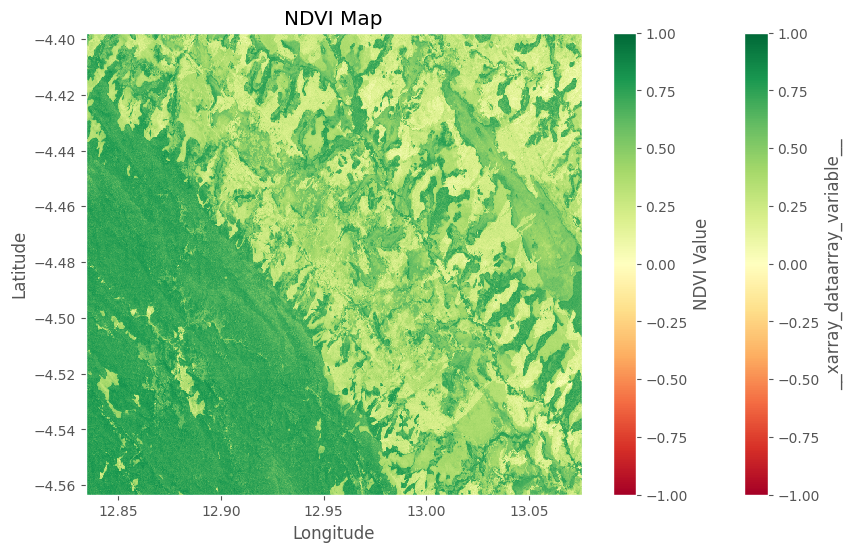

In [15]:
# Load the Zarr NDVI data stored in a raster dataset

log_progress('Loading Zarr dataset')

forest_loss_dataset = xr.open_zarr(ZARR_STORE, group="kimongo-etl-job", chunks='auto')

log_progress('Loading complete')
# Check dataset structure
display(forest_loss_dataset)

# Access NDVI DataArray (assuming the NDVI is stored in the first band)
ndvi_data = forest_loss_dataset['__xarray_dataarray_variable__'][0, :, :].squeeze()  # first band

log_progress('Creating NDVI Map')

# Plotting the NDVI map using the plot method directly
plt.figure(figsize=(10, 6))
ndvi_plot = ndvi_data.plot(cmap='RdYlGn', vmin=-1, vmax=1)  # Using the plot method for DataArrays
plt.title("NDVI Map")
plt.colorbar(ndvi_plot, label='NDVI Value') 
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

client.close()

log_progress('Map created. ETL workflow complete.')